In [1]:
import os.path

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
wa_ev_df = pd.read_csv('data/Washington_EV_Population_Data.csv')

In [4]:
len(wa_ev_df)

91933

In [5]:
### Data Pre-processing and Cleaning

In [6]:
def download_file(file_name: str): # wa_ev_registrations_public
    if not os.path.exists('data/{}.csv'.format(file_name)):
        import requests
        url = "https://www.atlasevhub.com/public/dmv/{}.csv".format(file_name)
        file = requests.get(url)
        print(file)
        with open('data/{}.csv'.format(file_name), 'wb') as text:
            text.write(file.content)

download_file('wa_ev_registrations_public')

In [18]:
wa_df = pd.read_csv('data/wa_ev_registrations_public.csv') # , nrows=20000
print(wa_df.dtypes)
wa_df['Valid Datetime'] = pd.to_datetime(wa_df['Registration Valid Date'])
print(wa_df.dtypes)

/Users/hyc/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Vehicle ID                      object
ZIP Code                        object
Registration Valid Date         object
VIN Prefix                      object
VIN Model Year                  object
DMV ID                           int64
DMV ID Complete                 object
DMV Snapshot                    object
Registration Expiration Date    object
State Abbreviation              object
Geography                       object
Vehicle Name                    object
Technology                      object
dtype: object
Vehicle ID                              object
ZIP Code                                object
Registration Valid Date                 object
VIN Prefix                              object
VIN Model Year                          object
DMV ID                                   int64
DMV ID Complete                         object
DMV Snapshot                            object
Registration Expiration Date            object
State Abbreviation                      object
Geography

In [19]:
# show the earliest and latest registration date, which also represents the data capture time period
min(wa_df['Valid Datetime']), max(wa_df['Valid Datetime'])

(Timestamp('2010-01-06 00:00:00'), Timestamp('2022-03-16 00:00:00'))

In [25]:

wa_df['Valid Month'] = wa_df['Registration Valid Date'].str[:-3]
wa_df['Valid Quarter'] = pd.PeriodIndex(wa_df['Valid Datetime'], freq='Q')
wa_df['Valid Year'] = wa_df['Registration Valid Date'].str[:4]
# count the Dynamic Type(Technology) for BEV/PHEV
wa_df['Dynamic Type'] = wa_df['Technology'].apply(lambda x: 1 if x == 'BEV' else 0)
wa_df_month = wa_df.groupby(['Valid Month'])\
    .agg({'Vehicle ID': 'count', 'Dynamic Type': 'sum'}).reset_index()\
    .rename(columns={'Vehicle ID': 'Vehicles Total Number', 'Dynamic Type': 'BEV Number'})

wa_df_month['PHEV Number'] = wa_df_month['Vehicles Total Number'] - wa_df_month['BEV Number']
print(wa_df_month)


    Valid Month  Vehicles Total Number  BEV Number  PHEV Number
0       2010-01                      1           1            0
1       2010-02                      5           5            0
2       2010-03                     13          13            0
3       2010-04                      9           9            0
4       2010-05                      7           7            0
..          ...                    ...         ...          ...
138     2021-11                  81787       60258        21529
139     2021-12                  83621       61811        21810
140     2022-01                  84762       62758        22004
141     2022-02                  84762       62758        22004
142     2022-03                  88903       66305        22598

[143 rows x 4 columns]


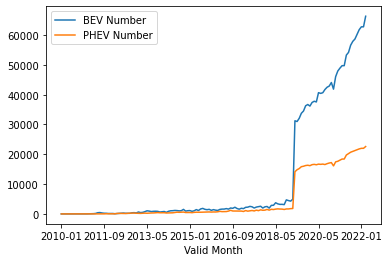

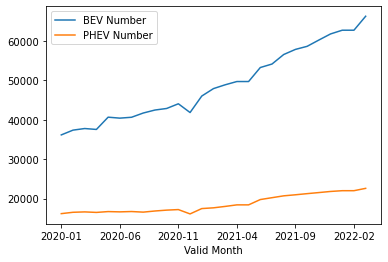

In [30]:
wa_df_month.plot(x='Valid Month', y={'PHEV Number', 'BEV Number'}, kind='line')
wa_df_month[wa_df_month['Valid Month'].str.startswith('202')].plot(x='Valid Month', y={'PHEV Number', 'BEV Number'}, kind='line')
plt.show()

        Vehicle Name Valid Quarter  Vehicles Quarterly Amount
800      Kia Niro EV        2019Q3                        135
801      Kia Niro EV        2019Q4                        458
802      Kia Niro EV        2020Q1                        815
803      Kia Niro EV        2020Q2                       1114
804      Kia Niro EV        2020Q3                       1249
805      Kia Niro EV        2020Q4                       1435
806      Kia Niro EV        2021Q1                       1733
807      Kia Niro EV        2021Q2                       2049
808      Kia Niro EV        2021Q3                       2638
809      Kia Niro EV        2021Q4                       3036
810      Kia Niro EV        2022Q1                       3376
1124      Polestar 2        2021Q1                         20
1125      Polestar 2        2021Q2                         35
1126      Polestar 2        2021Q3                         72
1127      Polestar 2        2021Q4                        290
1128    

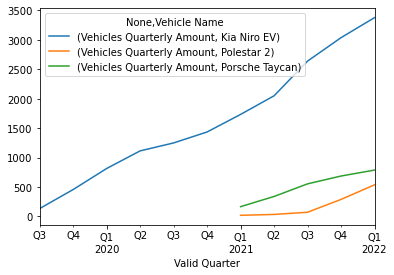

In [57]:
# draw multiple car quarterly data
def draw_vehicle_quarterly_data(car_list: [], subplot=False):
    wa_df_quarter = wa_df.groupby(['Vehicle Name', 'Valid Quarter'])\
        .agg({'Vehicle ID': 'count'}).reset_index()\
        .rename(columns={'Vehicle ID': 'Vehicles Quarterly Amount'})
    if len(car_list) == 0:
        print(wa_df_quarter)
        return
    wa_df_name_quarter = wa_df_quarter[wa_df_quarter['Vehicle Name'].isin(car_list)]
    print(wa_df_name_quarter)
    #wa_df_name_quarter.set_index('Valid Quarter').plot()
    '''
    plt.figure(figsize=(9,4), dpi= 100)
    tesla = wa_df_name_quarter[wa_df_name_quarter['Vehicle Name'] == 'Tesla Model 3']
    porsche = wa_df_name_quarter[wa_df_name_quarter['Vehicle Name'] == 'Porsche Taycan']
    plt.plot(x='Valid Quarter', y='Vehicles Quarterly Amount', linewidth = 0.8, marker = '.', label = "tesla", color='#E11B00')
    plt.plot(porsche, linewidth = 0.8, marker = '.', label = "porsche", color='#E11B00')
    '''
    da = pd.pivot(wa_df_name_quarter, index='Valid Quarter', columns='Vehicle Name')
    da.plot()
    print(da)
    plt.figure(figsize=(10,5), dpi=100)
    plt.xlabel('Quarter').ylabel('Vehicle Amount')
    plt.show()

#draw_vehicle_quarterly_data([])
draw_vehicle_quarterly_data(['Porsche Taycan', 'Kia Niro EV', 'Polestar 2'])
